### 一、导入

In [1]:
# -*- coding: utf-8 -*-
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,\
ExtraTreesClassifier,RandomForestClassifier,GradientBoostingRegressor,BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from ase import Atoms as ASE_Atoms
from ase.io import read as ASE_read
from dscribe.descriptors import ACSF,MBTR,SOAP,LMBTR
period_table = Chem.GetPeriodicTable()

In [2]:
df = pd.read_csv('./combined.csv', index_col=0)
# exo = df['exo/endo'].fillna(1,inplace=True)
# for index, row in df.iterrows():
#     result=str(row['exo/endo']).split(':')[0]
#     df.at[index,'exo/endo']=int(result)/(100-int(result))
# df['exo/endo']
press = df['Pressure/atm']
temp = df['Reaction Temperature/C']
s_c = df['S/C 1']
yie = df['Yield 1'].fillna(0, inplace=True)
ee = df['ee 1'].fillna(0, inplace=True)


def ee2ddG(row):
    ee = row['ee 1']
    T = row['Reaction Temperature/C']
    R = (1+ee/100)/2
    S = (1-ee/100)/2
    return -8.314*(T+273.15)*np.log(R/S)/1000/4.1858


df['ee 1'] = df.apply(ee2ddG,axis=1)

### 二、选择SMILES

In [3]:
cols = df.columns[:11]
smi_all = [col for col in cols if not df[col].isnull().all()]
smi_env = [
    key for key in smi_all if 'Catalyst' in key or 'Solvent' in key or 'Additive' in key]
smi_re = [i for i in smi_all if i not in smi_env]
print(smi_re)
print(smi_env)

['Reactant SMILES', 'Reactant SMILES_2', 'Product SMILES', 'Product SMILES_2', 'Ligand SMILES']
['Catalyst SMILES', 'Solvent SMILES', 'Solvent SMILES_2', 'Additive SMILES', 'Additive SMILES_2', 'Additive SMILES_s2']


### 三、生成描述符

In [4]:
#Mol2Atoms

def Mol2Atoms(mol):
    positions = mol.GetConformer().GetPositions()
    atom_types = [period_table.GetElementSymbol(atom.GetAtomicNum()) for atom in mol.GetAtoms()]
    atoms = ASE_Atoms(symbols=atom_types,positions=positions)
    return atoms
#onehot

from feature_engine.encoding import OneHotEncoder
def getOneHot(df,smi_env):
    df[smi_env]=df[smi_env].fillna(value="none")
    ohe = OneHotEncoder(variables=smi_env)
    df_encoded = ohe.fit_transform(df[smi_env])
    return df_encoded

#morganfp

def getmorganfp(smiles,radius=4,nBits=2048,useChirality=True):
    if smiles == 'nan' or not isinstance(smiles, str):
        return np.zeros(nBits)
    try:
        mol = Chem.MolFromSmiles(smiles)
        AllChem.AddHs(mol)
        fp = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,radius=radius,nBits=nBits,useChirality=useChirality)
        return list(map(eval,list(fp.ToBitString())))
    except:
        current_index = df.index[df[si] == smiles][0]
        df.drop(current_index,inplace=True)

#modred

from mordred import Calculator, descriptors
calc = Calculator(descriptors, ignore_3D=True)
descriptions = [desc.__str__() for desc in calc.descriptors]
def calc_modred_desc(smiles):
    if smiles == 'nan' or not isinstance(smiles, str):
        return np.zeros(len(descriptions))
    try:
        mol = Chem.MolFromSmiles(smiles)
        AllChem.AddHs(mol)
        modred_df = calc(mol)
        return modred_df
    except:
        current_index = df.index[df[si] == smiles][0]
        df.drop(current_index,inplace=True)

#rdkit

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import multiprocessing as mp
descs = [desc_name[0] for desc_name in Descriptors._descList]
desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)
def calculate_descriptors(smiles):
    if smiles == 'NaN' or not isinstance(smiles, str):
        return np.zeros(len(descs))
    try:
        mol = Chem.MolFromSmiles(smiles)
        AllChem.AddHs(mol)
        des = desc_calc.CalcDescriptors(mol)
        return des
    except:
        current_index = df.index[df[si] == smiles][0]
        df.drop(current_index,inplace=True)
#生成描述符，统一清洗
def get_new_df(df,smi,map_dict):
    new_df=pd.DataFrame()
    for i, si in enumerate(smi):
        temp_df = pd.DataFrame([map_dict[str(mols)] for mols in df[si]])
        temp_df = temp_df.apply(pd.to_numeric, errors='coerce').fillna(0)  # 处理异常值、空值
        # selector = SmartCorrelatedSelection(threshold=0.99, method='pearson')
        # temp_df=selector.fit_transform(temp_df)   #找到相关性高的特征，并只保留最高方差贡献率的特征
        temp_df.columns = temp_df.columns.astype(str)  # 将特征名称转换为字符串类型
        new_df = pd.concat([new_df, temp_df], axis=1)
    scaler = MinMaxScaler()    # 使用 MinMaxScaler 转换器进行归一化
    new_df = pd.DataFrame(scaler.fit_transform(new_df), columns=new_df.columns)
    # dcf=DropConstantFeatures(tol=1)
    # new_df=dcf.fit_transform(new_df)   #删除重复值
    return new_df


In [5]:
# all_smi = sorted(list(set([str(si) for row in smi_re for si in df[row]])))
# from ChemScript22 import *
# for i,smi in enumerate(all_smi):
#     if smi != 'nan':
#         m = StructureData.LoadData(smi)
#         m.ConvertTo3DStructure()
#         m.Mm2OptimizeGeometry()
#         sd =SDFileWriter.OpenFile(f'./sdf/{i}.sdf',OverWrite,"chemical/x-mdl-molfile-v2000")
#         sd.WriteStructure(m)
#         sd.Close()

In [6]:
all_smi = sorted(list(set([str(si) for row in smi_re for si in df[row]])))
all_mol_3d = []
all_atoms = []
smi_atoms_map = {}
smi_mol_map = {}
wrong_smi = []
for i,smi in enumerate(all_smi):
    if str(smi) != 'nan':
        suppl = Chem.SDMolSupplier('./sdf/'+str(i)+'.sdf')
        mol = AllChem.AddHs(suppl[0])
        try:
            AllChem.EmbedMolecule(mol)
            AllChem.MMFFOptimizeMolecule(mol)
            atoms = Mol2Atoms(mol)
            smi_atoms_map[smi] = atoms
        except:
            atoms = ASE_read('./sdf/'+str(i)+'.xyz',format='xyz')
            smi_atoms_map[smi] = atoms
            wrong_smi.append(smi)
        finally:
            smi_mol_map[smi] = mol


[22:27:37] UFFTYPER: Warning: hybridization set to SP3 for atom 18
[22:27:37] UFFTYPER: Warning: hybridization set to SP3 for atom 18
[22:27:39] UFFTYPER: Warning: hybridization set to SP3 for atom 7
[22:27:39] UFFTYPER: Warning: hybridization set to SP3 for atom 4
[22:27:52] UFFTYPER: Warning: hybridization set to SP3 for atom 12
[22:27:52] UFFTYPER: Unrecognized atom type: Fe5+2 (51)
[22:27:53] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[22:27:53] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[22:27:54] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[22:27:55] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[22:27:55] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[22:27:55] UFFTYPER: Warning: hybridization set to SP3 for atom 3
[22:27:55] UFFTYPER: Unrecognized atom type: Fe5+2 (25)
[22:27:55] UFFTYPER: Unrecognized atom type: Fe5+2 (25)
[22:27:56] UFFTYPER: Unrecognized atom type: Fe5+2 (38)
[22:27:56] UFFTYPER: Unrecognized atom type: Fe

In [7]:
re_species = []
for smi in list(set([si for row in smi_re[:-1] for si in df[row]])):
    if str(smi) == 'nan':
        continue
    re_species += [atom.GetSymbol() for atom in smi_mol_map[smi].GetAtoms()]
re_species = list(set(re_species))

lig_species = []
for smi in df[smi_re[-1]]:
    if str(smi) == 'nan':
        continue
    lig_species += [atom.GetSymbol() for atom in smi_mol_map[smi].GetAtoms()]
lig_species = list(set(lig_species))
lig_species,re_species

(['C', 'Si', 'Cl', 'F', 'P', 'N', 'O', 'Fe', 'S', 'H'],
 ['C', 'I', 'Si', 'Cl', 'Br', 'F', 'P', 'N', 'O', 'S', 'H'])

In [8]:
#mbtr

k1={
        "geometry": {"function": "atomic_number"},
        "grid": {"min": 0, "max": 8, "n": 10, "sigma": 0.1},
    }
k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 4, "n": 10, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    }
k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 4, "n": 10, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    }

re_mbtr = MBTR(species=re_species,k1=k1,k2=k2,k3=k3,periodic=False,normalization="l2_each")
lig_mbtr = MBTR(species=lig_species,k1=k1,k2=k2,k3=k3,periodic=False,normalization="l2_each")


#ACSF

rcut = 6.0
g2_params = [[1, 1], [1, 2], [1, 3]]
g4_params = [[1, 1, 1], [1, 2, 1], [1, 1, -1], [1, 2, -1]]

re_acsf = ACSF(species=re_species,rcut=rcut,g2_params=g2_params,g4_params=g4_params)
lig_acsf = ACSF(species=lig_species,rcut=rcut,g2_params=g2_params,g4_params=g4_params)

#soap
rcut = 6.0
nmax = 8
lmax = 6

re_soap = SOAP(species=re_species,periodic=False,rcut=rcut,nmax=nmax,lmax=lmax)
lig_soap = SOAP(species=lig_species,periodic=False,rcut=rcut,nmax=nmax,lmax=lmax)

#lmbtr
k2={
        "geometry": {"function": "distance"},
        "grid": {"min": 0, "max": 5, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    }
k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 4, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    }
re_lmbtr = LMBTR(species=re_species,k2=k2,k3=k3,periodic=False,normalization="l2_each")
lig_lmbtr = LMBTR(species=lig_species,k2=k2,k3=k3,periodic=False,normalization="l2_each")


smi_MF_map = {}
smi_Modred_map = {}
smi_rdkit_map = {}
smi_mbtr_map = {}
smi_acsf_map = {}
smi_soap_map = {}
smi_lmbtr_map = {}
for smi in list(set([str(si) for row in smi_re[:-1] for si in df[row]])):
    if smi != 'nan':
        smi_MF_map[smi] = getmorganfp(smi)
        smi_Modred_map[smi] = calc_modred_desc(smi)
        smi_rdkit_map[smi] = calculate_descriptors(smi)
        atom = smi_atoms_map[smi]
        smi_mbtr_map[smi] = re_mbtr.create(atom)
        acsf =np.mean(re_acsf.create(atom),axis=0)
        smi_acsf_map[smi] = acsf
        soap = np.mean(re_soap.create(atom),axis=0)
        smi_soap_map[smi] = soap
        lmbtr = np.mean(re_lmbtr.create(atom),axis=0)
        smi_lmbtr_map[smi] = lmbtr
for smi in list(set(df[smi_re[-1]])):
    if str(smi) != 'nan':
        smi_MF_map[smi] = getmorganfp(smi)
        smi_Modred_map[smi] = calc_modred_desc(smi)
        smi_rdkit_map[smi] = calculate_descriptors(smi)
        atom = smi_atoms_map[smi]
        smi_mbtr_map[smi] = lig_mbtr.create(atom)
        acsf = np.mean(lig_acsf.create(atom),axis=0)
        smi_acsf_map[smi] = acsf
        soap = np.mean(lig_soap.create(atom),axis=0)
        smi_soap_map[smi] = soap
        lmbtr = np.mean(lig_lmbtr.create(atom),axis=0)
        smi_lmbtr_map[smi] = lmbtr
smi_MF_map['nan'] = np.zeros(2048)
smi_Modred_map['nan'] = np.zeros(len(descriptions))
smi_rdkit_map['nan'] = np.zeros(len(descs))
smi_mbtr_map['nan'] = np.zeros(smi_mbtr_map[df[smi_re[0]][0]].shape)
smi_acsf_map['nan'] = np.zeros(smi_acsf_map[df[smi_re[0]][0]].shape)
smi_soap_map['nan'] = np.zeros(smi_soap_map[df[smi_re[0]][0]].shape)
smi_lmbtr_map['nan'] = np.zeros(smi_lmbtr_map[df[smi_re[0]][0]].shape)

/home/ys/anaconda3/envs/d2l/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [9]:
threeDs = [smi_MF_map,smi_Modred_map,smi_rdkit_map,smi_mbtr_map,smi_acsf_map,smi_soap_map,smi_lmbtr_map]
desc_names = ['MorganFP','Modred','Rdkit','MBTR','ACSF','SOAP','LMBTR','OneHot']
all_new_df= {}
env_onehot = getOneHot(df,smi_env)
for i,threeD in enumerate(threeDs):
    new_df = pd.DataFrame()
    if desc_names[i] != 'OneHot':
        new_df = get_new_df(df,smi_re,threeD)
    new_df=pd.concat([new_df,env_onehot],axis=1)
    all_new_df[desc_names[i]] = new_df

new_df=getOneHot(df,smi_re)
new_df=pd.concat([new_df,env_onehot],axis=1)
all_new_df[desc_names[-1]] = new_df

np.savez('./all_new_df.npz',all_new_df=all_new_df)

/home/ys/anaconda3/envs/d2l/lib/python3.9/site-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/home/ys/anaconda3/envs/d2l/lib/python3.9/site-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/home/ys/anaconda3/envs/d2l/lib/python3.9/site-packages/feature_engine/encoding/one_hot.py:277: PerformanceWarning

### 四、机器学习

In [12]:
models = [RandomForestRegressor(n_estimators=16,max_depth=5, random_state=0),
          ExtraTreesRegressor(n_jobs=-1,random_state=0),
          KNeighborsRegressor(n_jobs=-1),
          DecisionTreeRegressor(random_state=0),
          GradientBoostingRegressor(random_state=2023),
          BaggingRegressor(n_jobs=-1,random_state=2023)]
model_names = ['RF','ET','KNN','DT','GB','BG']
Yield_r2_map = np.zeros((len(desc_names),len(model_names)))
ddG_r2_map = np.zeros((len(desc_names),len(model_names)))

n_splits = 5 # 设置折数，这里设置为5

for i,new_df in enumerate(all_new_df.values()):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023) # 创建KFold对象
    for j,model in enumerate(models):
        yield_scores = [] # 数组用于存储每次折叠的分数
        ddg_scores = []
        for train_index, test_index in kf.split(new_df): # 将数据集拆分成训练和测试集
            x_train, x_test = new_df.iloc[train_index], new_df.iloc[test_index]
            y_train_yield, y_test_yield = df['Yield 1'].iloc[train_index], df['Yield 1'].iloc[test_index]
            y_train_ddg, y_test_ddg = df['ee 1'].iloc[train_index], df['ee 1'].iloc[test_index]

            history=model.fit(x_train, y_train_yield)
            predict=model.predict(x_test)
            yield_scores.append(r2_score(np.array(y_test_yield),predict))

            history=model.fit(x_train, y_train_ddg)
            predict=model.predict(x_test)
            ddg_scores.append(r2_score(np.array(y_test_ddg),predict))

        Yield_r2_map[i,j]=np.mean(yield_scores) # 取每次折叠的平均分数
        ddG_r2_map[i,j]=np.mean(ddg_scores)

In [20]:
# np.savez('./scores.npz',Yield_r2_map=Yield_r2_map,ddG_r2_map=ddG_r2_map)
models = [RandomForestRegressor(n_estimators=16,max_depth=5, random_state=0),
          ExtraTreesRegressor(n_jobs=-1,random_state=0),
          KNeighborsRegressor(n_jobs=-1),
          DecisionTreeRegressor(random_state=0),
          GradientBoostingRegressor(random_state=2023),
          BaggingRegressor(n_jobs=-1,random_state=2023)]
model_names = ['RF','ET','KNN','DT','GB']
desc_names = ['MorganFP','Modred','Rdkit','MBTR','ACSF','SOAP','LMBTR','OneHot']
Yield_r2_map=np.load('./scores.npz',allow_pickle=True)['Yield_r2_map']
ddG_r2_map=np.load('./scores.npz',allow_pickle=True)['ddG_r2_map']

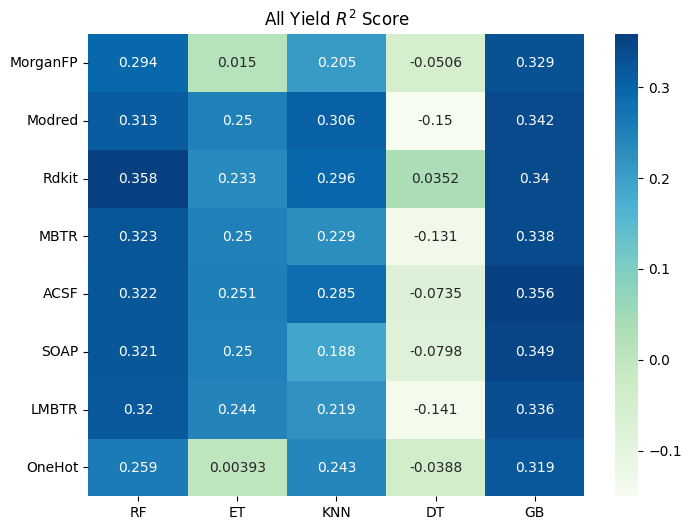

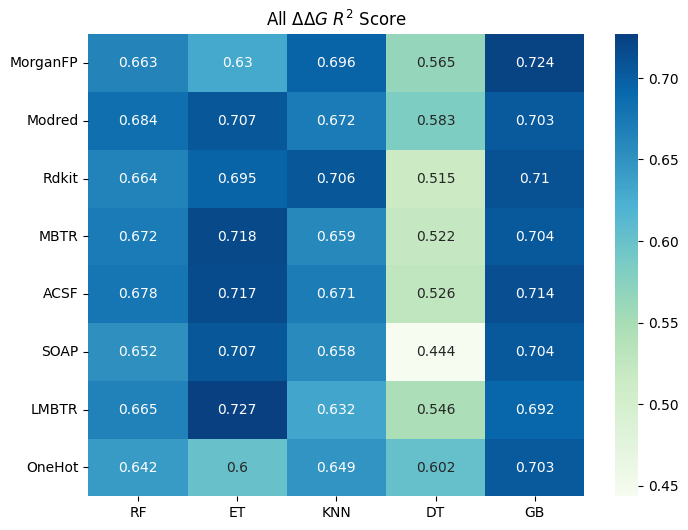

In [22]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(Yield_r2_map[:,:-1],annot=True,fmt='.3g',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu')
plt.title('All Yield $R^2$ Score')
plt.show()
fig = plt.figure(figsize=(8,6))
sns.heatmap(ddG_r2_map[:,:-1],annot=True,fmt='.3g',xticklabels=model_names,yticklabels=desc_names,cmap='GnBu')
plt.title('All $\Delta \Delta G$ $R^2$ Score')
plt.show()
